<a href="https://colab.research.google.com/github/rfvassallo/ComputerVisonClasses/blob/master/lesson08-epipolar_constraint/epipolar_lines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16


     |████████████████████████████████| 25.0MB 1.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20
     |████████████████████████████████| 30.6MB 194kB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


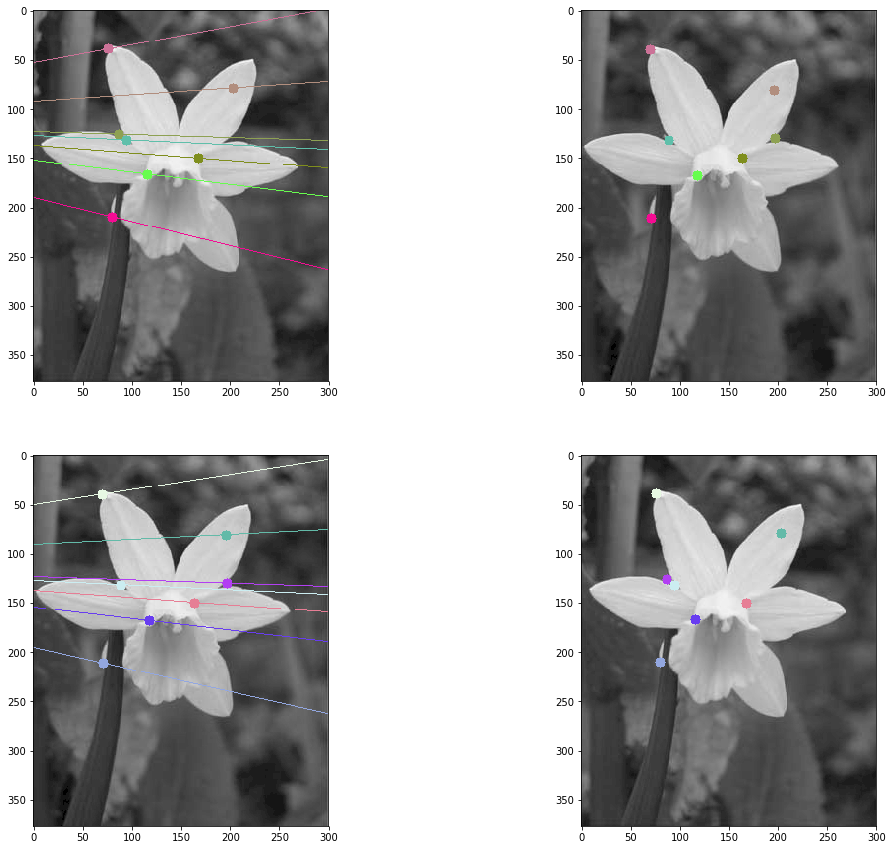

In [16]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Additional function to draw the epipolar lines

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2



# Read left and right images
img1 = cv.imread('testc1.png',0)  #queryimage # left image
img2 = cv.imread('testc2.png',0) #trainimage # right image

# find the keypoints and descriptors with SIFT
sift = cv.xfeatures2d.SIFT_create()
#sift = cv.SIFT()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Solve matching between detected points in both images
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
good = []
pts1 = []
pts2 = []

# Select good matches
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):

    if m.distance < 0.6*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

        

#Find Fundamental Matrix

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)#,1,0.9999)
# cv.FM_RANSAC


# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]



# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
fig=plt.figure(figsize=(18,15))
fig.add_subplot(2,2,1)
plt.imshow(img5)
fig.add_subplot(2,2,2)
plt.imshow(img6)
fig.add_subplot(2,2,3)
plt.imshow(img3)
fig.add_subplot(2,2,4)
plt.imshow(img4)
plt.show()